In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -q "/content/drive/MyDrive/Conglomerate Concrete Crack Detection.zip"

In [ ]:
import tensorflow as tf
import os

def load_image_mask(image_path, mask_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, channels=3)
  image = tf.image.resize(image, (256, 256))
  image = tf.cast(image, tf.float32) / 255

  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels=1)
  mask = tf.image.resize(mask, (256, 256))
  mask = tf.cast(mask, tf.float32) / 255

  return image, mask

def augment(image, mask):
  if tf.random.uniform(()) > 0.5:
    image = tf.image.random_flip_left_right(image)
    mask = tf.image.random_flip_left_right(mask)

  if tf.random.uniform(()) > 0.5:
    image = tf.image.random_flip_up_down(image)
    mask = tf.image.random_flip_up_down(mask)

  if tf.random.uniform(()) > 0.5:
    image = tf.image.random_brightness(image, 0.1)

  if tf.random.uniform(()) > 0.5:
    image = tf.image.random_contrast(image, 0.9, 1.1)

  return image, mask

def create_dataset(image_path, mask_path, batch_size=16, augment_data=False):
  image_paths = sorted([os.path.join(image_path, fname) for fname in os.listdir(image_path)])
  mask_paths = sorted([os.path.join(mask_path, fname) for fname in os.listdir(mask_path)])

  dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
  dataset = dataset.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)

  if augment_data:
    dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

  dataset = dataset.shuffle(buffer_size=1000) if augment_data else dataset
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)

  return dataset

train_dataset = create_dataset(image_path = "/content/Conglomerate Concrete Crack Detection/Train/images",
                               mask_path = "/content/Conglomerate Concrete Crack Detection/Train/masks",
                               augment_data = True)

val_dataset = create_dataset(image_path = "/content/Conglomerate Concrete Crack Detection/Test/images",
                               mask_path = "/content/Conglomerate Concrete Crack Detection/Test/masks")



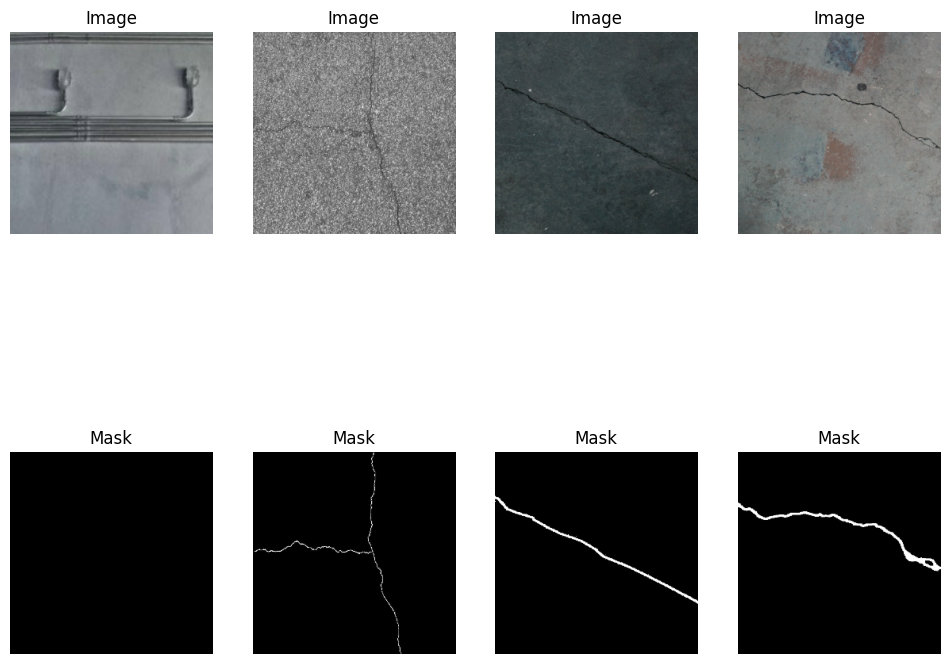

In [ ]:
import matplotlib.pyplot as plt
import random

image_paths = "/content/Conglomerate Concrete Crack Detection/Train/images"
mask_paths = "/content/Conglomerate Concrete Crack Detection/Train/masks"

image_paths = sorted([os.path.join(image_paths, fname) for fname in os.listdir(image_paths)])
mask_paths = sorted([os.path.join(mask_paths, fname) for fname in os.listdir(mask_paths)])

idx = random.sample(range(len(image_paths)), 4)

plt.figure(figsize=(12, 10))

for i in range(len(idx)):
  img, msk = load_image_mask(image_paths[idx[i]], mask_paths[idx[i]])
  plt.subplot(2, 4, i+1)
  plt.imshow(img)
  plt.title('Image')
  plt.axis("off")
  plt.subplot(2, 4, i+5)
  plt.imshow(msk, cmap = 'gray')
  plt.title('Mask')
  plt.axis("off")
plt.show()

In [ ]:
def conv_block(inputs, num_filters):
  x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.Dropout(0.5)(x)

  x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.Dropout(0.5)(x)


  return x

def encoder_block(inputs, num_filters):
  x = conv_block(inputs, num_filters)
  p = tf.keras.layers.MaxPool2D((2, 2))(x)
  return x, p

def decoder_block(inputs, skip_features, num_filters):
  x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
  x = tf.keras.layers.Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x

def build_unet(input_shape):
  inputs = tf.keras.layers.Input(shape = input_shape)

  s1, p1 = encoder_block(inputs, 32)
  s2, p2 = encoder_block(p1, 64)
  s3, p3 = encoder_block(p2, 128)
  s4, p4 = encoder_block(p3, 256)

  b1 = conv_block(p4, 512)

  d1 = decoder_block(b1, s4, 256)
  d2 = decoder_block(d1, s3, 128)
  d3 = decoder_block(d2, s2, 64)
  d4 = decoder_block(d3, s1, 32)

  outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

  model = tf.keras.Model(inputs, outputs, name="U-Net")
  return model

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>

In [ ]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>

In [ ]:
model = build_unet((256, 256, 3))

In [ ]:
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 256, 256,  │          0 │ activation_18[0]… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 256, 256,  │      9,248 │ dropout_18[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 256, 256,  │          0 │ activation_19[0]… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ dropout_19[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 128, 128,  │          0 │ activation_20[0]… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │     36,928 │ dropout_20[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 128, 128,  │          0 │ batch_normalizat

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(train_dataset, validation_data=val_dataset, epochs=2)

In [ ]:
def dice_loss(y_true, y_pred, smooth=1):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  intersection = tf.reduce_sum(y_true * y_pred)
  union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

  dice = (2. * intersection + smooth) / (union + smooth)
  return 1 - dice

def bce_dice_loss(y_true, y_pred):
  bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)(y_true, y_pred)
  dice = dice_loss(y_true, y_pred)
  return bce + dice

def dice_coef(y_true, y_pred, smooth=1):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred > 0.5, tf.float32)

  intersection = tf.reduce_sum(y_true * y_pred)
  union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

  dice = (2. * intersection + smooth) / (union + smooth)
  return dice

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=bce_dice_loss,
              metrics=[dice_coef])

In [ ]:
model.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/5
619/619 ━━━━━━━━━━━━━━━━━━━━ 338s 439ms/step - dice_coef: 0.1281 - loss: 1.4903 - val_dice_coef: 0.1305 - val_loss: 1.1421
Epoch 2/5
619/619 ━━━━━━━━━━━━━━━━━━━━ 232s 370ms/step - dice_coef: 0.1278 - loss: 1.1508 - val_dice_coef: 0.1140 - val_loss: 1.0747
Epoch 3/5
619/619 ━━━━━━━━━━━━━━━━━━━━ 260s 365ms/step - dice_coef: 0.2448 - loss: 1.0611 - val_dice_coef: 0.0734 - val_loss: 1.0502
Epoch 4/5
619/619 ━━━━━━━━━━━━━━━━━━━━ 228s 364ms/step - dice_coef: 0.3168 - loss: 0.9973 - val_dice_coef: 0.0940 - val_loss: 1.0406
Epoch 5/5
619/619 ━━━━━━━━━━━━━━━━━━━━ 229s 365ms/step - dice_coef: 0.3436 - loss: 0.9605 - val_dice_coef: 0.0594 - val_loss: 1.0601


In [ ]:
def visualise_predictions(model, image_dir, mask_dir, num_samples=5, alpha=0.4):
  image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
  mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

  sample_indices = random.sample(range(len(image_paths)), num_samples)

  for i, idx in enumerate(sample_indices):
    img, msk = load_image_mask(image_paths[idx], mask_paths[idx])

    pred_mask = model.predict(tf.expand_dims(img, axis=0))[0]

    img = img.numpy()
    msk = msk.numpy()

    msk_rgb = tf.concat([msk, msk, msk], axis=-1).numpy()
    pred_rgb = tf.concat([pred_mask, pred_mask, pred_mask], axis=-1)

    gt_overlay = img.copy()

    gt_overlay[msk_rgb[:,:,0]>0.5] = [1, 0, 0]

    pred_overlay = img.copy()
    pred_overlay[pred_rgb[:,:,0]>0.5] = [0, 1, 0]

    blended_gt = (1 - alpha) * img + alpha * gt_overlay
    blended_pred = (1 - alpha) * img + alpha * pred_overlay

    plt.subplot(num_samples, 2, 2*i+1)
    plt.imshow(blended_gt)
    plt.title(f'Ground Truth {idx}')
    plt.axis("off")

    plt.subplot(num_samples, 2, 2*i+2)
    plt.imshow(blended_pred)
    plt.title(f'Predicted Mask {idx}')
    plt.axis("off")

  plt.tight_layout()
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


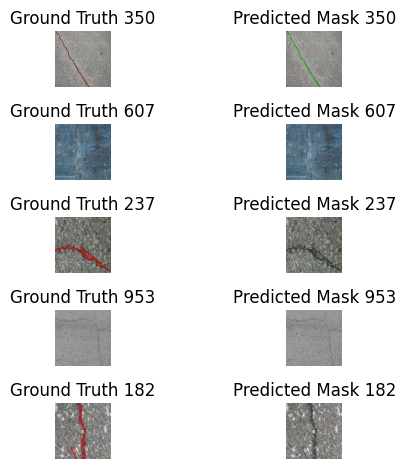

In [ ]:
image_dir = "/content/Conglomerate Concrete Crack Detection/Test/images"
mask_dir = "/content/Conglomerate Concrete Crack Detection/Test/masks"

visualise_predictions(model, image_dir, mask_dir, num_samples=5)